In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='3,4,5,6'

import time
import itertools

import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torchvision.models.resnet as resnet

from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils
import torch.autograd as autograd
# from torch.nn.utils import weight_norm

from sklearn.model_selection import train_test_split

# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True

from torch.backends import cudnn
cudnn.benchmark = True

device1 = torch.device("cuda:0")
device2 = torch.device("cuda:1")
device3 = torch.device("cuda:2")
device4 = torch.device("cuda:3")

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='nearest'),
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels)
                                )

    def forward(self, x):
        return x + self.res(x)
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
        
class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)
    
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [3]:
# def load_data(size):
#     hfs = 48 # half full size 96/2=48
#     hs = size//2
#     start = hfs-hs
#     end = hfs+hs
    
#     X = (np.load('X_clean.npy')[:, start:end, start:end] - 127.5) / 127.5
#     X = np.moveaxis(X, -1, 1).astype(np.float32)
#     y = np.load('Y_clean.npy').reshape(-1,1).astype(np.float32)
#     wsi = np.load('WSI_clean.npy')
    
# #     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# #     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
# #     X_0 = torch.from_numpy(X[WSI==0])
# #     X_1 = torch.from_numpy(X[WSI==1])
# #     Y_0 = torch.from_numpy(Y[WSI==0])
# #     Y_1 = torch.from_numpy(Y[WSI==1])
# #     return X_0, Y_0, X_1, Y_1

#     return X, y, wsi

In [4]:
# X, y, wsi = load_data(48)

# X_test = torch.from_numpy(X)
# y_test = torch.from_numpy(y)

# idx0 = wsi==0
# idx1 = wsi==1

# _, X0_test, _, y0_test = train_test_split(X_test[idx0], y_test[idx0], test_size=0.2, random_state=0)
# _, X1_test, _, y1_test = train_test_split(X_test[idx1], y_test[idx1], test_size=0.2, random_state=0)

# # TODO: RANDOM SAMPLE

# X0 = X[idx0]
# X1 = X[idx1]
# y0 = y[idx0]
# y1 = y[idx1]

# n = min(X0.shape[0], X1.shape[0])


# X0 = torch.from_numpy(X0[:n])
# X1 = torch.from_numpy(X1[:n])

# trainloader = DataLoader(TensorDataset(X0, X1), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)


In [5]:
# X0_train = np.concatenate([np.load('X0_train_clean_48.npy'), np.load('X0_val_clean_48.npy')])
# X1_train = np.concatenate([np.load('X1_train_clean_48.npy'), np.load('X1_val_clean_48.npy')])

X0_train = np.load('X0_train_clean_48.npy')
X1_train = np.load('X1_train_clean_48.npy')


# n = min(X0_train.shape[0], X1_train.shape[0])

X0_train = torch.from_numpy((X0_train - .5) / .5)
X1_train = torch.from_numpy((X1_train - .5) / .5)



In [6]:
trainloader_A = DataLoader(X0_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
trainloader_B = DataLoader(X1_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [7]:
class ResNet(resnet.ResNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self._forward_impl(x))
    
@torch.no_grad()
def eval_G(G, clf, validation_loader, g_device, clf_device):
    G.eval()
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0].to(g_device)
        y = data[1].to(clf_device)
        X_g = G(X).to(clf_device)
        predicted = torch.round(clf(0.5 * (X_g + 1.0)))
        acc+=(predicted == y).sum()/float(predicted.shape[0])     
#             acc_g+=(predicted_g == y).sum()/float(predicted_g.shape[0])     
    G.train()
    return (acc/(i+1)).detach().item()

@torch.no_grad()
def eval_Clf(model, validation_loader, device):
    acc = .0
    for i, data in enumerate(validation_loader):
        X = data[0].to(device)
        y = data[1].to(device)
        predicted = torch.round(model(0.5 * (X + 1.0)))
        acc+=(predicted == y).sum()/float(predicted.shape[0])       
    return (acc/(i+1)).detach().item()

In [8]:
X0_test = (np.load('X0_val_clean_48.npy') - .5) / .5
y0_test = np.load('y0_val_clean_48.npy')

X1_test = (np.load('X1_val_clean_48.npy') - .5) / .5
y1_test = np.load('y1_val_clean_48.npy')

X0_test = torch.from_numpy(X0_test)
y0_test = torch.from_numpy(y0_test)
X1_test = torch.from_numpy(X1_test)
y1_test = torch.from_numpy(y1_test)


testloader0 = DataLoader(TensorDataset(X0_test, y0_test), batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
testloader1 = DataLoader(TensorDataset(X1_test, y1_test), batch_size=128, shuffle=True, num_workers=1, pin_memory=True)

In [9]:
ClfA = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
ClfB = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
ClfA.load_state_dict(torch.load('results/clf_resnet18_48/best_model.pth'))
ClfB.load_state_dict(torch.load('results/clf_resnet18_48/best_model.pth'))
ClfA = ClfA.to(device3)
ClfB = ClfB.to(device4)
ClfA.eval()
ClfB.eval()

print('Acc for A:', eval_Clf(ClfA, testloader0, device3))
print('Acc for B:', eval_Clf(ClfB, testloader1, device4))

Acc for A: 0.8580536842346191
Acc for B: 0.8817319273948669


In [10]:
netG_B2A = Generator().to(device1)
netD_A = Discriminator().to(device1)
netG_A2B = Generator().to(device2)
netD_B = Discriminator().to(device2)

netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

cycle_loss1 = torch.nn.L1Loss().to(device1)
cycle_loss2 = torch.nn.L1Loss().to(device2)
identity_loss1 = torch.nn.L1Loss().to(device1)
identity_loss2 = torch.nn.L1Loss().to(device2)
adversarial_loss1 = torch.nn.MSELoss().to(device1)
adversarial_loss2 = torch.nn.MSELoss().to(device2)

def gradient_penalty(D, real_data, generated_data, device):
    batch_size = real_data.shape[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data).to(device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # Calculate probability of interpolated examples
    dis_interpolated = D(interpolated)
    grad_outputs = torch.ones(dis_interpolated.shape).to(device)

    # Calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=dis_interpolated, inputs=interpolated,
                           grad_outputs=grad_outputs, create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)
#         self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = ((torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12) - 1) ** 2).mean()
    # Return gradient penalty
    return 10*gradients_norm

# lambda_gp = 10
lr = 0.0002
betas = (0.5, 0.999)
# itertools.chain takes a series of iterables and return them as one long iterable.
optimizer_G = Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=betas)
optimizer_D_A = Adam(netD_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = Adam(netD_B.parameters(), lr=lr, betas=betas)

epochs = 200
decay_epochs = 100
lr_lambda = DecayLR(epochs, 0, decay_epochs).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

g_losses = []
d_losses_A = []
d_losses_B = []
acc_a = []
acc_b = []

identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [11]:
folder = 'cyclegan_48_wgan_1_val2'
path = 'results/'+folder
path_imgs = path +'/samples'
if not os.path.exists('results'):
    os.mkdir('results')
if not os.path.exists(path):
    os.mkdir(path)
if not os.path.exists(path_imgs):
    os.mkdir(path_imgs)
if not os.path.exists(path_imgs+'/A'):
    os.mkdir(path_imgs+'/A')
if not os.path.exists(path_imgs+'/B'):
    os.mkdir(path_imgs+'/B')
    
print(
    f" Iter.\t"
    f"LossD A\t"
    f"LossD B\t"
    f" Loss G\t"
    f"Acc B2A\t"
    f"Acc A2B")

    
best_mean_acc = 0
early_stop_cnt = 0

iter_A = iter(trainloader_A)
iter_B = iter(trainloader_B)

for i in range(1, 200001):
    try:
        data_A = next(iter_A)
    except:
        iter_A = iter(trainloader_A)
        data_A = next(iter_A)

    try:
        data_B = next(iter_B)
    except:
        iter_B = iter(trainloader_B)
        data_B = next(iter_B)

    # get batch size data
    real_image_A1 = data_A.to(device1)
    real_image_B1 = data_B.to(device1)
    real_image_A2 = data_A.to(device2)
    real_image_B2 = data_B.to(device2)

    batch_size = real_image_A1.size(0)

    # real data label is 1, fake data label is 0.
    real_label1 = torch.full((batch_size, 1), 1, device=device1, dtype=torch.float32)
    fake_label1 = torch.full((batch_size, 1), 0, device=device1, dtype=torch.float32)
    real_label2 = torch.full((batch_size, 1), 1, device=device2, dtype=torch.float32)
    fake_label2 = torch.full((batch_size, 1), 0, device=device2, dtype=torch.float32)

    ##############################################
    # (1) Update G network: Generators A2B and B2A
    ##############################################

    # Set G_A and G_B's gradients to zero
    optimizer_G.zero_grad()

    # Identity loss
    # G_B2A(A) should equal A if real A is fed
    identity_image_A = netG_B2A(real_image_A1)
    loss_identity_A = identity_loss1(identity_image_A, real_image_A1) * 5.0
    # G_A2B(B) should equal B if real B is fed
    identity_image_B = netG_A2B(real_image_B2)
    loss_identity_B = identity_loss2(identity_image_B, real_image_B2) * 5.0

    # GAN loss D_A(G_A(A))
    fake_image_A = netG_B2A(real_image_B1)
    fake_output_A = netD_A(fake_image_A)
#         loss_GAN_B2A = adversarial_loss1(fake_output_A, real_label1)
    # WGAN
    loss_GAN_B2A = -fake_output_A.mean()

    # GAN loss D_B(G_B(B))
    fake_image_B = netG_A2B(real_image_A2)
    fake_output_B = netD_B(fake_image_B)
#         loss_GAN_A2B = adversarial_loss2(fake_output_B, real_label2)
    # WGAN
    loss_GAN_A2B = -fake_output_B.mean()

    # Cycle loss
    recovered_image_A = netG_B2A(fake_image_B.to(device1))
    loss_cycle_ABA = cycle_loss1(recovered_image_A, real_image_A1) * 10.0

    recovered_image_B = netG_A2B(fake_image_A.to(device2))
    loss_cycle_BAB = cycle_loss2(recovered_image_B, real_image_B2) * 10.0

    torch.cuda.synchronize()
    # Combined loss and calculate gradients
    errG = loss_identity_A.cpu() + loss_identity_B.cpu() + loss_GAN_A2B.cpu() + loss_GAN_B2A.cpu() + loss_cycle_ABA.cpu() + loss_cycle_BAB.cpu()

    g_losses.append(errG.item())
    # Calculate gradients for G_A and G_B
    errG.backward()
    # Update G_A and G_B's weights
    optimizer_G.step()

    ##############################################
    # (2) Update D network: Discriminator A
    ##############################################

    # Set D_A gradients to zero
    optimizer_D_A.zero_grad()

    # Real A image loss
    real_output_A = netD_A(real_image_A1)
#         errD_real_A = adversarial_loss1(real_output_A, real_label1)
    # WGAN
    errD_real_A = real_output_A.mean()

    # Fake A image loss
    fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
    fake_output_A = netD_A(fake_image_A.detach().to(device1))
#         errD_fake_A = adversarial_loss1(fake_output_A, fake_label1)
    # WGAN
    errD_fake_A = fake_output_A.mean()

    # Combined loss and calculate gradients
#         errD_A = (errD_real_A + errD_fake_A) / 2
    # WGAN
    gp_A = gradient_penalty(netD_A, real_image_A1, netG_B2A(real_image_B1), device1)
    errD_A = (errD_fake_A - errD_real_A + gp_A)

    d_losses_A.append(errD_A.item())

    # Calculate gradients for D_A
    errD_A.backward()
    # Update D_A weights
    optimizer_D_A.step()

    ##############################################
    # (3) Update D network: Discriminator B
    ##############################################

    # Set D_B gradients to zero
    optimizer_D_B.zero_grad()

    # Real B image loss
    real_output_B = netD_B(real_image_B2)
#         errD_real_B = adversarial_loss2(real_output_B, real_label2)
    # WGAN
    errD_real_B = real_output_B.mean()

    # Fake B image loss
    fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
    fake_output_B = netD_B(fake_image_B.detach().to(device2))
#         errD_fake_B = adversarial_loss2(fake_output_B, fake_label2)
    # WGAN
    errD_fake_B = fake_output_B.mean()

    # Combined loss and calculate gradients
#         errD_B = (errD_real_B + errD_fake_B) / 2
    # WGAN
    gp_B = gradient_penalty(netD_B, real_image_B2, netG_A2B(real_image_A2), device2)
    errD_B = (errD_fake_B - errD_real_B + gp_B)

    d_losses_B.append(errD_B.item())

    # Calculate gradients for D_B
    errD_B.backward()
    # Update D_B weights
    optimizer_D_B.step()
        
#     torch.cuda.synchronize()
    if i%100 == 0:
        accA = eval_G(netG_B2A, ClfA, testloader1, device1, device3)
        accB = eval_G(netG_A2B, ClfB, testloader0, device2, device4)
        
        acc_a.append(accA)
        acc_b.append(accB)

        print(
            f"{i:06d}\t"
            f"{d_losses_A[-1]:2.4f}\t"
            f"{d_losses_B[-1]:2.4f}\t"
            f"{g_losses[-1]:2.4f}\t"
            f"{accA:2.4f}\t"
            f"{accB:2.4f}")
    
        mean_acc = accA+accB
        if mean_acc < best_mean_acc:
            early_stop_cnt+= 1
        else:
            early_stop_cnt = 0
            best_mean_acc = mean_acc
            # save last check pointing
            torch.save(netG_A2B.state_dict(), path+"/netG_A2B.pth")
            torch.save(netG_B2A.state_dict(), path+"/netG_B2A.pth")
            torch.save(netD_A.state_dict(), path+"/netD_A.pth")
            torch.save(netD_B.state_dict(), path+"/netD_B.pth")

#         if early_stop_cnt > 19:
#             break
    
    if i%1000 == 0:
        fake_image_A = 0.5 * (netG_B2A(real_image_B1).data[:16] + 1.0)
        fake_image_B = 0.5 * (netG_A2B(real_image_A2).data[:16] + 1.0)

        vutils.save_image(fake_image_A.detach(),
                        path_imgs+f"/A/{i:06d}_fake.png",
                        normalize=True)
        vutils.save_image(fake_image_B.detach(),
                        path_imgs+f"/B/{i:06d}_fake.png",
                        normalize=True)

    if i%500 == 0:
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()


np.save(path+'/d_losses_A.npy', d_losses_A)
np.save(path+'/d_losses_B.npy', d_losses_B)
np.save(path+'/g_losses.npy', g_losses)
np.save(path+'/acc_a.npy', acc_a)
np.save(path+'/acc_b.npy', acc_b)

 Iter.	LossD A	LossD B	 Loss G	Acc B2A	Acc A2B
000100	-5.0595	-2.9262	1.0747	0.4540	0.4888
000200	-2.4434	-5.0575	3.0300	0.5804	0.4791
000300	-5.2997	0.2367	14.7653	0.4434	0.4853
000400	-1.5935	-1.3210	0.2929	0.5941	0.5661
000500	-1.5052	-0.6665	-2.6631	0.6248	0.5722
000600	-1.9640	-1.0046	-6.1029	0.4799	0.5782
000700	-1.6289	-2.3081	-5.1288	0.6029	0.6182
000800	-1.6775	-2.9692	-4.3924	0.6648	0.5561
000900	-0.6351	-0.7558	-12.1686	0.6353	0.6265
001000	-0.0840	-0.8553	-14.0309	0.5395	0.5725
001100	-0.5770	-0.9768	-10.3388	0.5093	0.5610
001200	-0.2776	-0.6777	-11.1434	0.6526	0.5418
001300	-0.4189	-0.6895	-8.9020	0.6474	0.5672
001400	-0.9539	-0.8483	-10.8619	0.6255	0.6220
001500	-0.4718	0.1154	-9.2233	0.6396	0.6426
001600	-0.9278	0.2432	-8.9478	0.7426	0.5913
001700	-0.8591	-0.8695	-8.6523	0.6976	0.6179
001800	-0.4686	-0.7912	-4.6761	0.6514	0.4904
001900	-0.5582	-0.0921	-5.4090	0.5913	0.6588
002000	-0.4637	-0.8867	-6.0353	0.5382	0.5906
002100	-0.0829	-0.6872	-5.0734	0.4824	0.6214
002200	-0

KeyboardInterrupt: 

(0.7774020433425903, 0.7025582790374756)

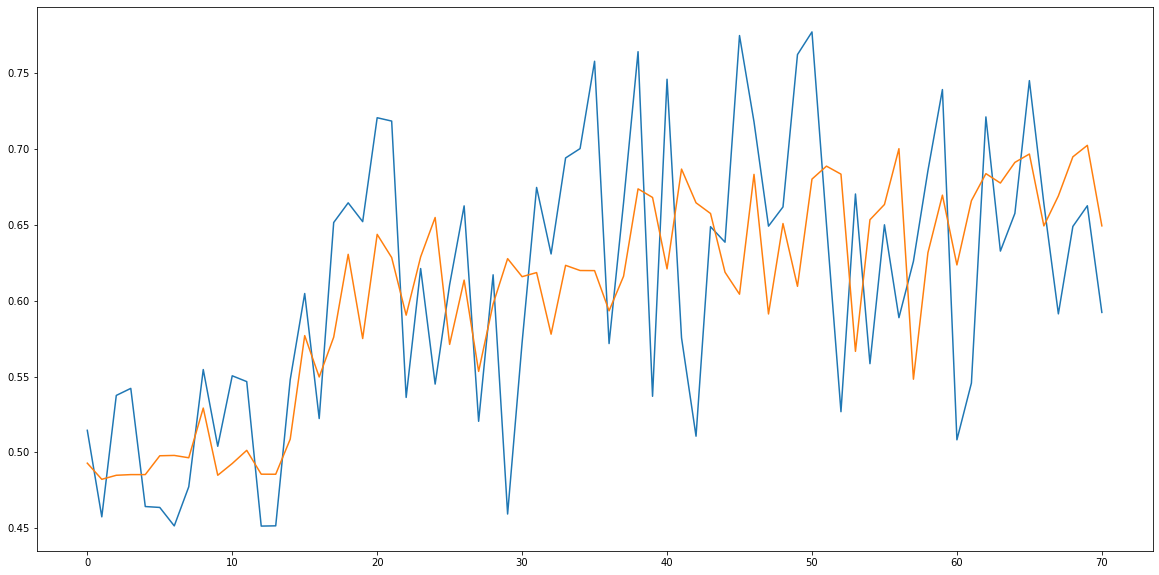

In [12]:
plt.figure(figsize=(20,10))
plt.plot(acc_a)
plt.plot(acc_b)
# print('Acc for A:', eval_Clf(ClfA, testloader0, device3))
# print('Acc for B:', eval_Clf(ClfB, testloader1, device4))
max(acc_a), max(acc_b)

In [ ]:
list(ClfA.named_children())

In [14]:
acc_a[-1], acc_b[-1]

(0.6978389024734497, 0.6619467735290527)

In [12]:
torch.save(netG_A2B.state_dict(), path+"/netG_A2B.pth")
torch.save(netG_B2A.state_dict(), path+"/netG_B2A.pth")
torch.save(netD_A.state_dict(), path+"/netD_A.pth")
torch.save(netD_B.state_dict(), path+"/netD_B.pth")

In [50]:
from torchsummary import summary

In [53]:
summary(netD_A, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,136
         LeakyReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3          [-1, 128, 24, 24]         131,200
    InstanceNorm2d-4          [-1, 128, 24, 24]               0
         LeakyReLU-5          [-1, 128, 24, 24]               0
            Conv2d-6          [-1, 256, 12, 12]         524,544
    InstanceNorm2d-7          [-1, 256, 12, 12]               0
         LeakyReLU-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 512, 11, 11]       2,097,664
   InstanceNorm2d-10          [-1, 512, 11, 11]               0
        LeakyReLU-11          [-1, 512, 11, 11]               0
           Conv2d-12            [-1, 1, 10, 10]           8,193
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
---------------------------

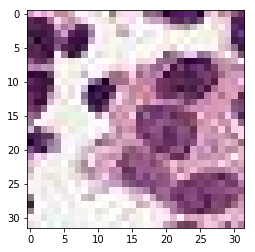

In [26]:
plt.imshow(.5+.5*np.transpose(x_train_0[90], (1, 2, 0)))

torch.Size([2, 3, 32, 32])

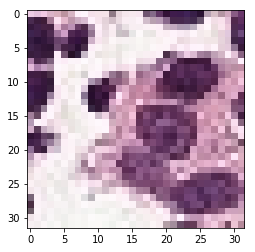

In [44]:
out_img = netG_A2B(x_train_0[90:92].to(device))
plt.imshow(.5+.5*np.transpose(out_img.cpu().detach()[0], (1, 2, 0)))
out_img.shape

out_img1 = netG_B2A(out_img)
plt.imshow(.5+.5*np.transpose(out_img1.cpu().detach()[0], (1, 2, 0)))
out_img.shape